Trong notebook này, nhóm trình bày phương pháp tìm số lượng topic và phát sinh topic tương ứng. 

#### import các thư viện cần thiết

In [1]:
import os
from collections import Counter
import nltk
import gensim  #for topic modelling
from bs4 import BeautifulSoup #for extracting text 
import nltk # for text preprocessing
import re 
import pandas as pd
import numpy as np
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import string
from sklearn.decomposition import NMF
import matplotlib 
import matplotlib.pyplot as plt
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
matplotlib.rcParams['figure.figsize'] = (20,10)
import numpy as np
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### đọc dữ liệu 

In [2]:
path = './inaugural_speeches/'
files = [path + fname for fname in os.listdir(path)]

In [3]:
data = []
for fname in files:
    with open(fname, 'r') as f:
        lines = ' '.join(f.readlines())
        data.append(lines)

####  bỏ các stopwords, các từ phổ biến , punctuation, pos tag

định nghĩa một số từ phổ biến và stopword 

In [4]:
stoplist = set([u'state', u'country', u'nation', u'people', u'constitution',u'duty', u'government', u'citizen', u'law', u'right', u'union',u'power', u'year', u'world', u'interest', u'purpose', u'justice',u'principle', u'it', u'time', u'question', u'executive', u'war',u'peace', u'life', u'institution', u'condition', u'effort', u'land',u'faith', u'place', u'office', u'today', u'thing', u'opinion',u'home', u'action', u'god', u'cause', u'century', u'strength', u'danger', u'revenue',u'subject',u'republic', 'ha', 'man', 'men', 'day', 'hope', 'u'])

bỏ các dấu câu, lowercase, chỉ giữ lại các danh từ

In [5]:
stop = set(stopwords.words('english'))
stop.update(stoplist)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    doc_filter = " ".join([word for word, pos in nltk.pos_tag(normalized.lower().split()) if pos=='NN' ])
    stop_free = ' '.join([i for i in doc_filter.split() if i not in stop])

    #doc_count = pd.Series(stop_free).value_counts()
    #doc_count = set(doc_count[doc_count==1].index.values)
    #new_words = ' '.join([w for w in stop_free if w not in doc_count])
    
    return stop_free

In [6]:
doc_clean = [clean(doc).split() for doc in data]

#### đồ thị phân bố của pos tag

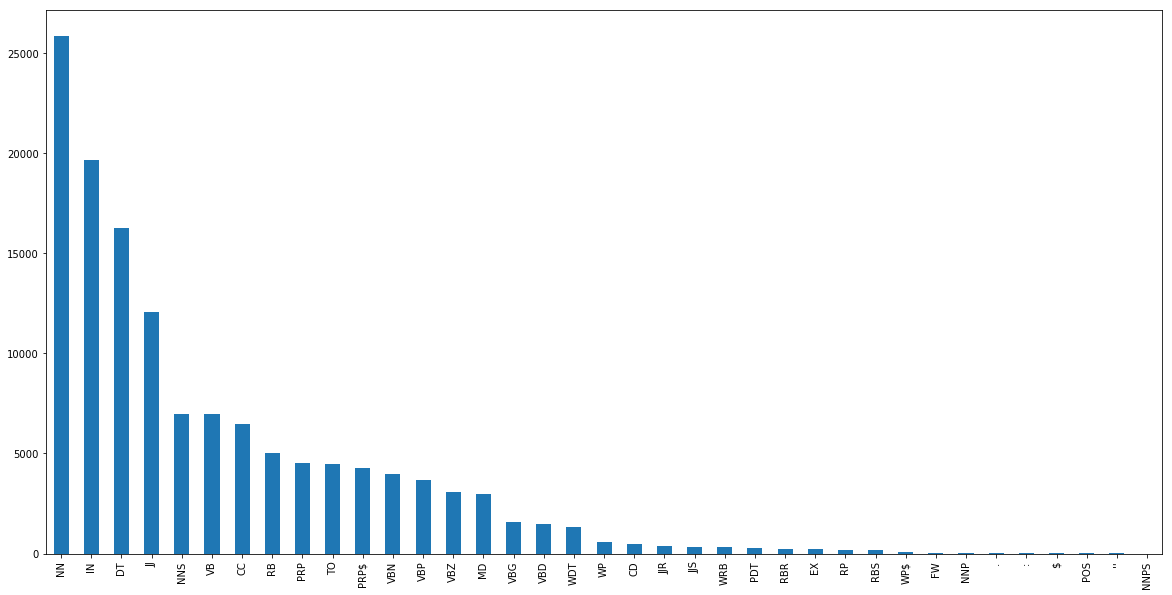

In [7]:
pos = [pos for doc in data for word, pos in nltk.pos_tag(doc.lower().split())]
pos = pd.Series(pos)
pos.value_counts().head(50).plot.bar()

#### đồ thị phần bố số lượng từ của các từ

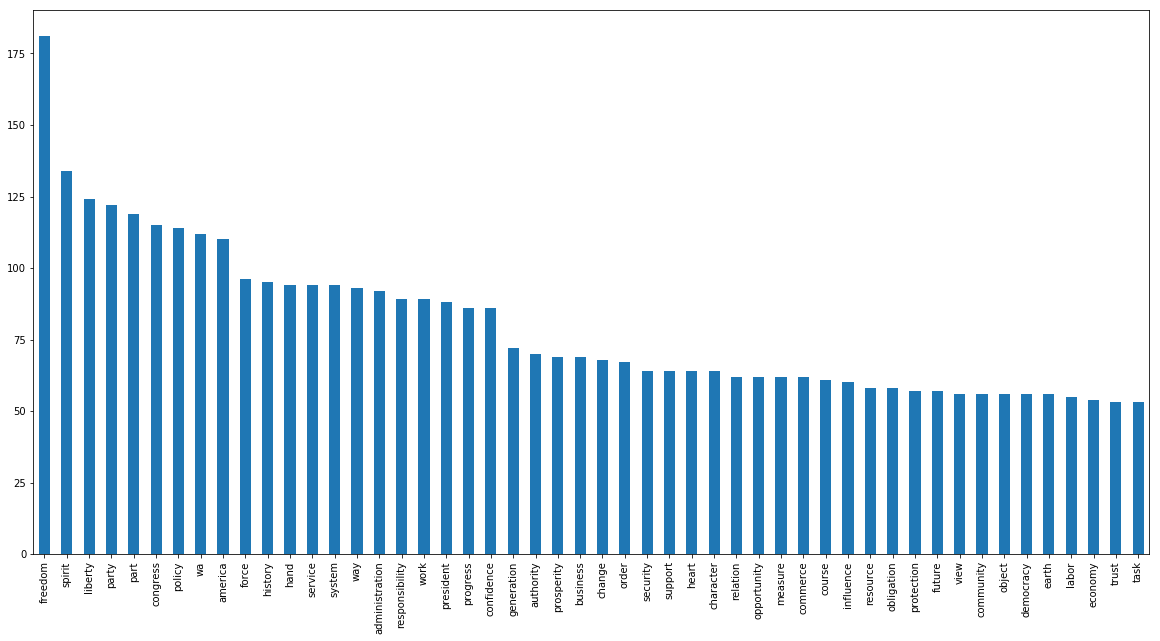

In [8]:
all_tokens = [x for y in doc_clean for x in y]
all_tokens = pd.Series(all_tokens)
all_tokens.value_counts().head(50).plot.bar()

#### hiển thị chủ đề của một vài transcripts

(-0.5, 399.5, 199.5, -0.5)

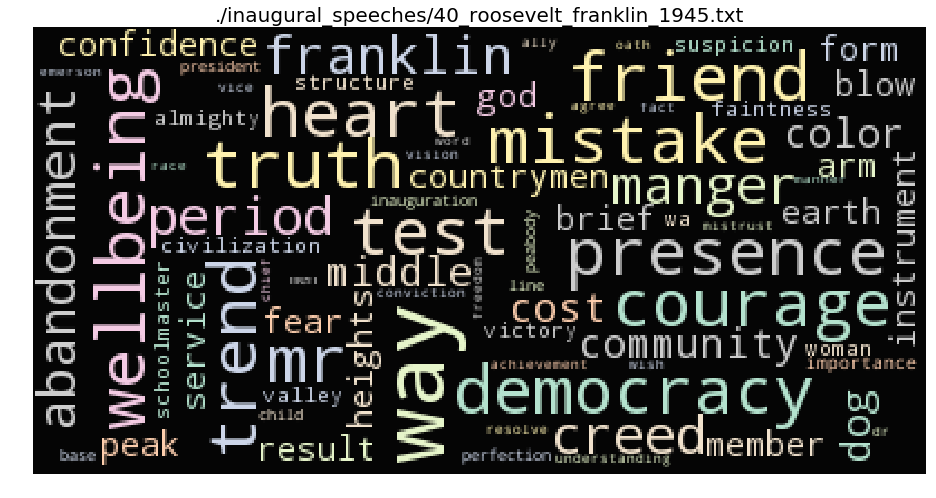

In [9]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[0]))
plt.title(files[0], fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

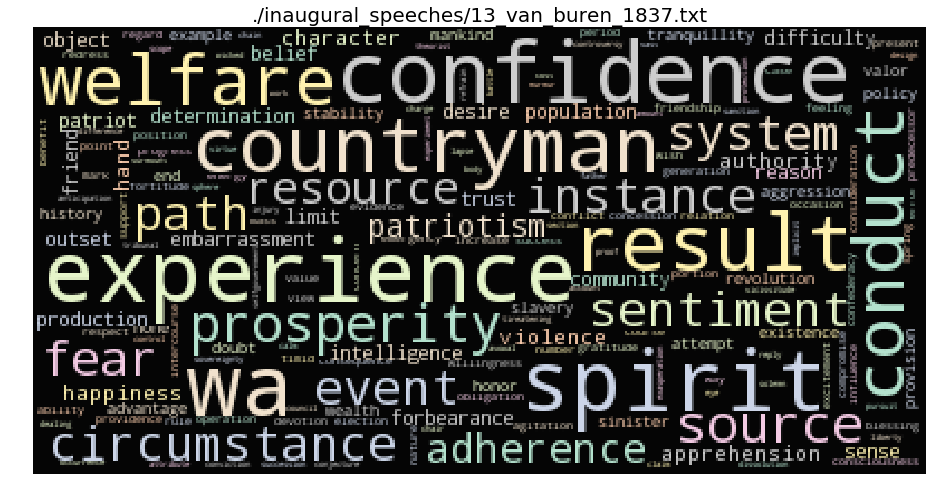

In [10]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[1]))
plt.title(files[1], fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

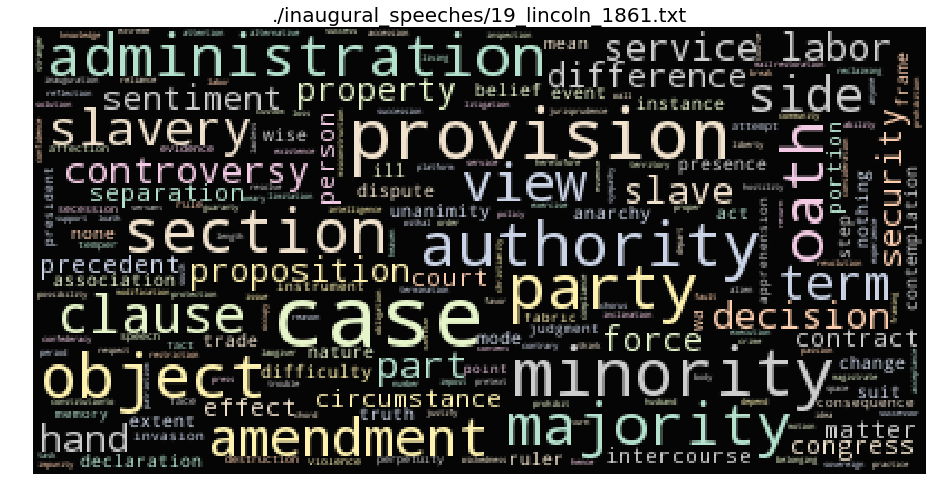

In [11]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(' '.join(doc_clean[23]))
plt.title(files[23], fontsize=20)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

#### tìm số topic bằng elbow trên không gian tf-idf

 tìm biểu diễn của các văn bản bằng tf-ifd

In [12]:
doc = [clean(doc) for doc in data]
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.95, min_df=2)
wordvector_fit = wordvector.fit_transform(doc)
feature = wordvector.get_feature_names()

chạy k từ 1 đến 50 để xác định điểm elbow, tuy nhiên ta thấy rằng trong không gian tf-idf không tồn tại điểm này.

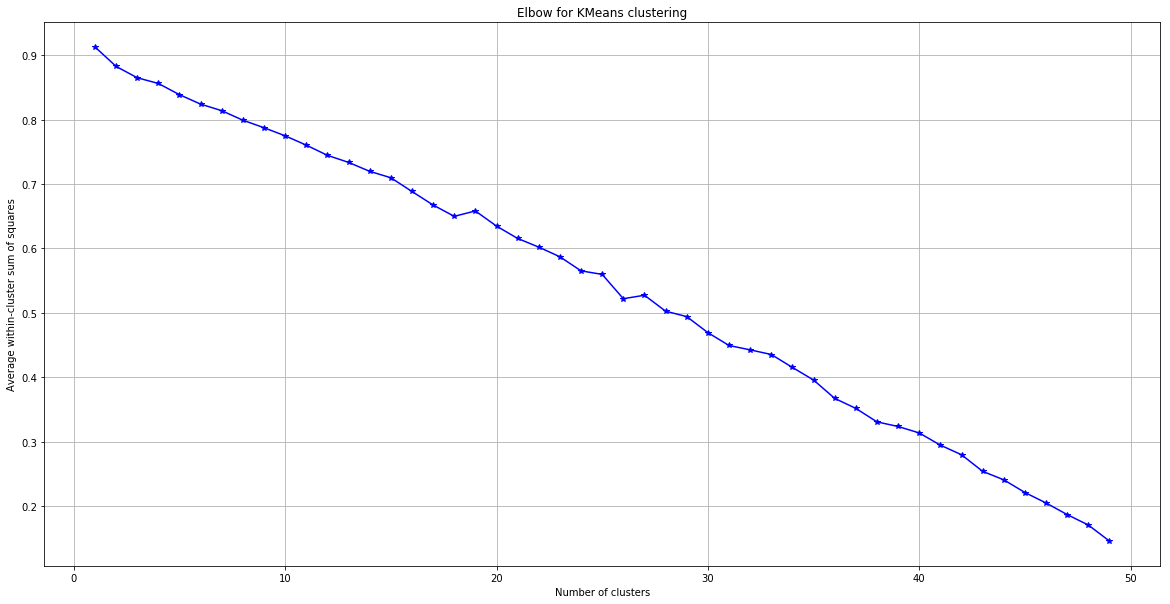

In [14]:

X = wordvector_fit.todense()

K = range(1,50)

KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

##### plot ###
kIdx = 2

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')

plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')


#### tìm điểm elbow trên không gian biểu diễn học bởi doc2vec

load vector biểu diễn học bởi doc2vec của các mẫu trong dữ liệu 

In [15]:
docvector = np.loadtxt('docvector.csv')

tìm điểm elbow của thuật toán kmean

In [16]:
N = 6
clf = KMeans(n_clusters=N,
            max_iter=100,
            init='k-means++',
            n_init=1)
labels = clf.fit_predict(docvector)

In [17]:
pca = PCA(n_components=2).fit(docvector)
docpoint = pca.transform(docvector)

Dựa vào đồ thị bên dưới ta xác định điểm elbow có k = 6

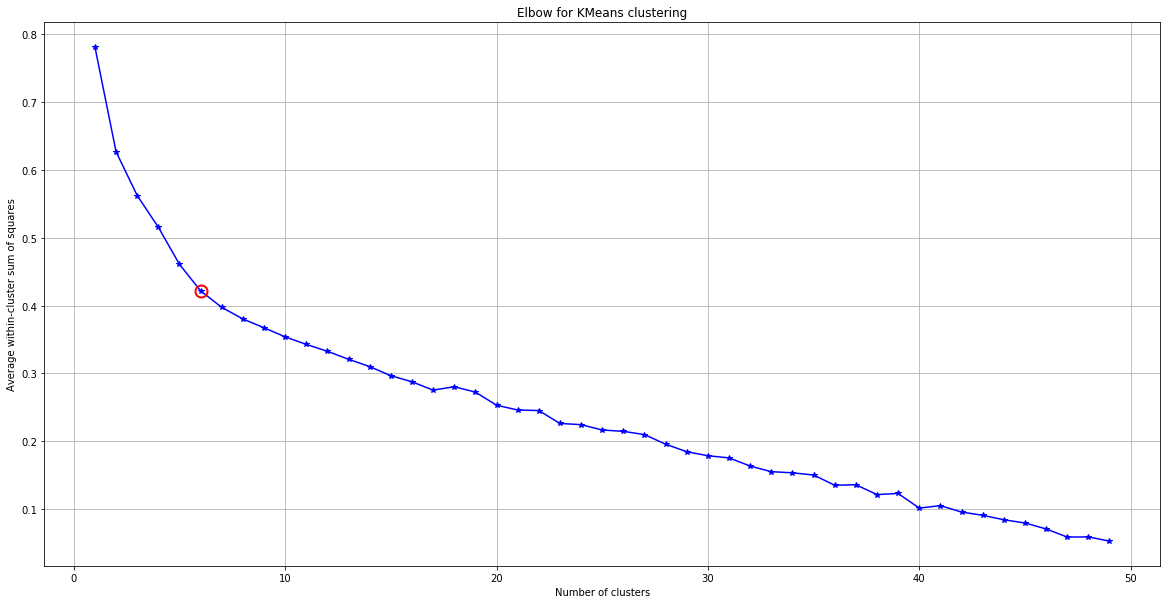

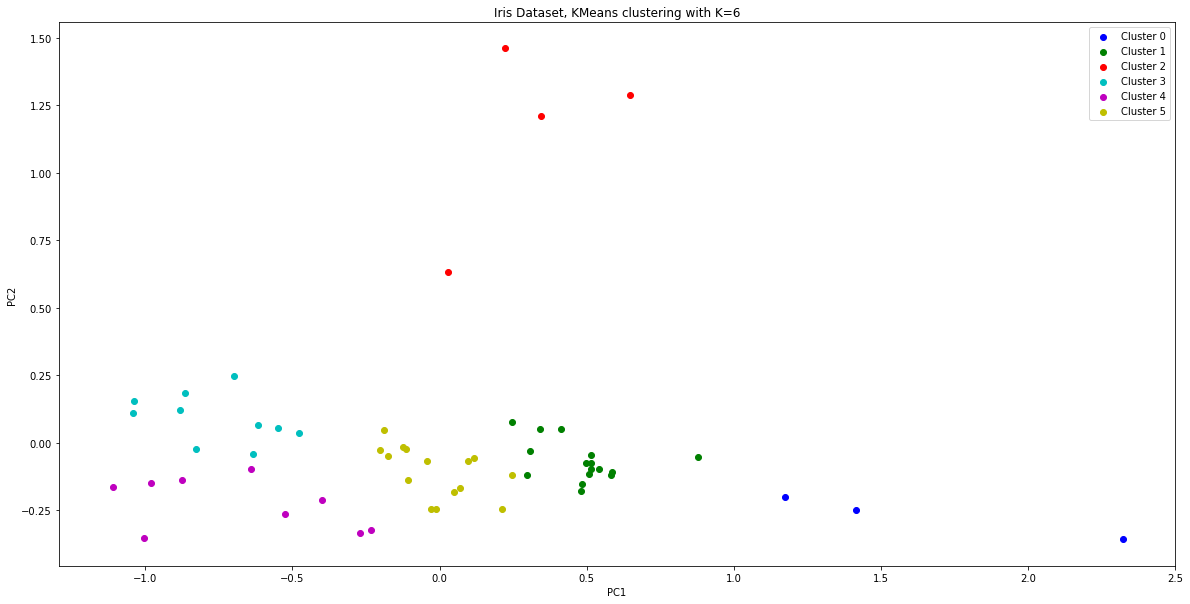

In [18]:
X = docvector

K = range(1,50)

KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

##### plot ###
kIdx = 5

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

# scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)
clr = ['b','g','r','c','m','y','k']
for i in range(K[kIdx]):
    ind = (cIdx[kIdx]==i)
    ax.scatter(docpoint[ind,0],docpoint[ind,1], c=clr[i],  label='Cluster %d'%i)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Iris Dataset, KMeans clustering with K=%d' % K[kIdx])
plt.legend()

plt.show()

#### lda để xác định topic tương ứng với k = 6

In [19]:
word_counts = pd.Series(np.concatenate(doc_clean)).value_counts()
singular_words = set(word_counts[pd.Series(np.concatenate(doc_clean)).value_counts() <= 2].index)
doc_stemmed = [[word for word in title if word not in singular_words] for title in doc_clean]

non_empty_indices = [i for i in range(len(doc_stemmed)) if len(doc_stemmed[i]) > 0]
doc_stemmed = np.asarray(doc_stemmed)[non_empty_indices]

dictionary = gensim.corpora.Dictionary(doc_stemmed)
corpus = [dictionary.doc2bow(text) for text in doc_stemmed]

model =  gensim.models.ldamodel.LdaModel
ldamodel = model(corpus, num_topics=6, id2word = dictionary, passes=200)

hiển thị topic bằng genmis

In [20]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      38.767147        1       1  0.064434  0.013524
5      29.560395        1       2  0.135582 -0.018508
4      20.977709        1       3 -0.142207  0.022134
3       5.195167        1       4 -0.127158 -0.103273
0       3.500326        1       5  0.109736 -0.032426
1       1.999257        1       6 -0.040388  0.118549, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
1421  Default  169.000000         freedom  169.000000  30.0000  30.0000
568   Default  101.000000         america  101.000000  29.0000  29.0000
338   Default   85.000000             way   85.000000  28.0000  28.0000
1185  Default   51.000000       democracy   51.000000  27.0000  27.0000
825   Default   82.000000  responsibility   82.000000  26.0000  26.0000
1314  Default   80.000000        progress   80.000000  25.0000  25.0000
804   Default   88.000000         history   88.000000  24.0000  24.0000
634   Default  125.000000          spirit  125.000000  23.0000  23.0000
1151  Default   46.000000             let   46.000000  22.0000  22.0000
34    Default   53.000000      protection   53.000000  21.0000  21.0000
82    Default   81.000000       president   81.000000  20.0000  20.0000
427   Default   64.000000          change   64.000000  19.0000  19.0000
487   Default  108.000000          policy  108.000000  18.0000  18.0000
1329  Default   42.000000         problem   42.000000  17.0000  17.0000
875   Default   42.000000          reason   42.000000  16.0000  16.0000
1454  Default   34.000000           limit   34.000000  15.0000  15.0000
91    Default   63.000000           order   63.000000  14.0000  14.0000
224   Default   28.000000            debt   28.000000  13.0000  13.0000
1222  Default   32.000000           truth   32.000000  12.0000  12.0000
65    Default   83.000000            work   83.000000  11.0000  11.0000
166   Default   53.000000          object   53.000000  10.0000  10.0000
857   Default   67.000000      generation   67.000000   9.0000   9.0000
1060  Default   35.000000    civilization   35.000000   8.0000   8.0000
269   Default   58.000000     opportunity   58.000000   7.0000   7.0000
451   Default   60.000000           heart   60.000000   6.0000   6.0000
827   Default   24.000000           dream   24.000000   5.0000   5.0000
1249  Default   89.000000          system   89.000000   4.0000   4.0000
666   Default   37.000000      instrument   37.000000   3.0000   3.0000
244   Default   47.000000           child   47.000000   2.0000   2.0000
183   Default   52.000000           earth   52.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
698    Topic6    2.606472            road   17.440074   2.0116  -5.0331
1222   Topic6    3.774121           truth   32.878295   1.7477  -4.6630
1185   Topic6    5.103491       democracy   51.317892   1.6043  -4.3612
338    Topic6    6.499092             way   85.360349   1.3372  -4.1195
747    Topic6    2.755506           woman   30.435334   1.5104  -4.9775
1343   Topic6    1.355267         climate    9.727614   1.9414  -5.6871
144    Topic6    1.355234      convention    9.772380   1.9368  -5.6872
706    Topic6    1.355322             lot    9.796698   1.9344  -5.6871
1114   Topic6    1.436118       structure   10.876451   1.8877  -5.6292
1060   Topic6    2.751032    civilization   35.850845   1.3450  -4.9792
1314   Topic6    3.917805        progress   80.124689   0.8943  -4.6256
666    Topic6    2.606426      instrument   37.908568   1.2352  -5.0332
1164   Topic6    1.743153         process   17.854359   1.5858  -5.4354
1329   Topic6    2.606416         problem   42.011639   1.1324  -5.0332
560    Topic6    2.152438           ideal   31.324248   1.2346  -5.2245
943    Topic6    2.137052         courage   30.899529   1.2411  -5.23

#### tìm topic tương ứng với doc

In [34]:
for idx, fname in enumerate(files):
    topics = [str(topic[0])for topic in ldamodel.get_document_topics(corpus[idx])]
    print("văn bản {} có topics là {}".format(fname[21:], ' và '.join(topics)))

văn bản 40_roosevelt_franklin_1945.txt có topics là 1
văn bản 13_van_buren_1837.txt có topics là 2 và 5
văn bản 20_lincoln_1865.txt có topics là 4 và 5
văn bản 3_adams_john_1797.txt có topics là 2 và 4 và 5
văn bản 6_madison_1809.txt có topics là 2 và 5
văn bản 42_eisenhower_1953.txt có topics là 2 và 3 và 4
văn bản 27_cleveland_1893.txt có topics là 2 và 5
văn bản 31_taft_1909.txt có topics là 2
văn bản 53_clinton_1997.txt có topics là 3 và 4
văn bản 55_bush_george_w_2005.txt có topics là 4
văn bản 12_jackson_1833.txt có topics là 2 và 4 và 5
văn bản 44_kennedy_1961.txt có topics là 4
văn bản 28_mckinley_1897.txt có topics là 2
văn bản 9_monroe_1821.txt có topics là 2 và 5
văn bản 16_taylor_1849.txt có topics là 5
văn bản 54_bush_george_w_2001.txt có topics là 4
văn bản 36_hoover_1929.txt có topics là 2
văn bản 51_bush_george_h_w_1989.txt có topics là 4
văn bản 32_wilson_1913.txt có topics là 2 và 4
văn bản 24_garfield_1881.txt có topics là 2 và 4
văn bản 25_cleveland_1885.txt có topi